# Hierarchical coin flips

We define a hierarchical coin flip model. The mode of the prior on all coin flip probabilities of landing heads, $\omega$, is drawn from a beta distribution. The individual coins are beta distributed with $\omega$ as their mode and $\kappa$ as concentration. To transform $\omega,\kappa$ into beta parameters $a,b$ we need a link function.

$$
\begin{align*}
    \kappa &= 10\\
    \omega &\sim \text{beta}(10, 1)\\
    a_\theta &= \omega(\kappa-2) + 1\\
    b_\theta &= (1-\omega)(\kappa-2) + 1\\
    \theta_j &\sim \text{beta}(a_\theta, b_\theta) \\
    y_{ij} &\sim \text{Bernoulli}(\theta_i) \enspace,
\end{align*}
$$

where $j=1, \ldots, m$ are the number of coins, and $i=1, \ldots, n$ the (shared) number of coin flips per coin.

In [13]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '5'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting CUDA visible devices to [5]


In [14]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from distrax._src.distributions.distribution import Distribution
from distrax._src.bijectors.bijector import Bijector

import os
import sys

from blackjax import normal_random_walk, hmc, nuts, elliptical_slice
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, mcmc_inference_loop, run_chain, smc_inference_loop


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Distrax version:    ', dx.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

Python version:      3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:         0.4.35
BlackJax version:    1.2.4
Distrax version:     0.1.5
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


# Modelling in bamojax 

## Nodes
A node can be one of three types:

1. A stochastic, latent node. This implies it is provided a `distribution` parameter.
2. A stochastic, observed node. This implies it is provided a `distribution` parameter, but also `observations`. 
3. A deterministic, observed node. This implies the node is _not_ provided a distribution parameter.

## Distributions

Distributions can be instantiated concrete distrax.Distribution objects, such as `dx.Beta(alpha=1, beta=1)`. Alternatively, the distribution is an uninstantiated object like `dx.Beta`. In the latter case, the `parents` of the node provide the input arguments to the distribution object.

## Parents

The `parents` argument is a dictionary with parameter names as keys, and `Node` or concrete `Array` objects as values. In the example below, the `parents` of `theta` are both the variable `omega` and the concrete value 15 for parameter `conc`. The latter is implemented by bamojax by creating an additional deterministic, observed node called `conc_theta` with `observations=15`.

Note that the keys omega and conc do not match the required parameters for a Beta distribution (in distrax, these should receive parameters alpha and beta). The link function `mode2ab` is a reference to a function that rewrites the arguments `mode` and `conc` into `alpha` and `beta`, and returns this as a new dictionary.

This is also needed for the Bernoulli distribution, as in distrax it can be parametrized either by probabilities or their logits, and it needs to be passed as an explicit keyword which of the two is used.

In [15]:
key = jrnd.PRNGKey(42)
# link functions take parent names and transform them into the kwargs for the child distribution.
def mode2ab(mode, conc):
    a = mode*(conc-2) + 1
    b = (1 - mode)*(conc-2) + 1
    return {'alpha': a, 'beta': b}

#
def theta2probs(probs):
    return {'probs': probs}

#

mode = 0.8
conc = 15
abdict = mode2ab(mode, conc)
a = abdict['alpha']
b = abdict['beta']
m = 10
n = 200

key, key_theta, key_y = jrnd.split(key, 3)
thetas = dx.Beta(alpha=a, beta=b).sample(seed=key_theta, sample_shape=(m, ))
ys = 1.0*dx.Bernoulli(probs=thetas).sample(seed=key_y, sample_shape=(n, ))

HierarchicalCoinflips = Model('hcf')
omega = HierarchicalCoinflips.add_node('omega', distribution=dx.Beta(alpha=10.0, beta=1.0))
theta = HierarchicalCoinflips.add_node('theta', distribution=dx.Beta, parents=dict(mode=omega, conc=15), link_fn=mode2ab, shape=(m, ))
y = HierarchicalCoinflips.add_node('y', distribution=dx.Bernoulli, parents=dict(probs=theta), observations=ys, link_fn=theta2probs, shape=(n, ))

print('Gibbs conditionals: ')
HierarchicalCoinflips.print_gibbs()

Gibbs conditionals: 
Gibbs structure:
omega               : p(theta | conc_theta, omega) p(omega)
theta               : p(y | theta) p(theta | conc_theta, omega)


Plotting functions for the toy model posterior:

In [16]:
def plot_states(position, color, title):

    fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(18, 3))
    ax = axes[0]
    ax.plot([0, 1], [0, 1], ls='--', color='k', zorder=-5)
    ax.scatter(thetas, jnp.mean(position['theta'], axis=0), s=60, edgecolors='k', c=color)
    ax.set_xlabel(r'True $\theta$')
    ax.set_ylabel(r'Estimated $\theta$')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1]);

    ax = axes[1]
    ax.hist(position['omega'].flatten(), bins=30,  density=True, facecolor=color, edgecolor='k');
    ax.axvline(x=mode, ls='--', color='k')
    ax.set_xlabel(r'$\omega$')
    ax = axes[2]
    ax.plot(position['omega'].flatten(), color=color)
    ax.axhline(y=mode, ls='--', color='k')
    ax.set_xlim([0, position['omega'].shape[0]])
    ax.set_xlabel('Sample index')
    ax.set_ylabel(r'$\omega$')

    plt.suptitle(title)
    return fig, axes

#

## Standard MCMC

### RMH

Acceptance rate: 0.267
CPU times: user 4.58 s, sys: 2.32 s, total: 6.89 s
Wall time: 6.51 s


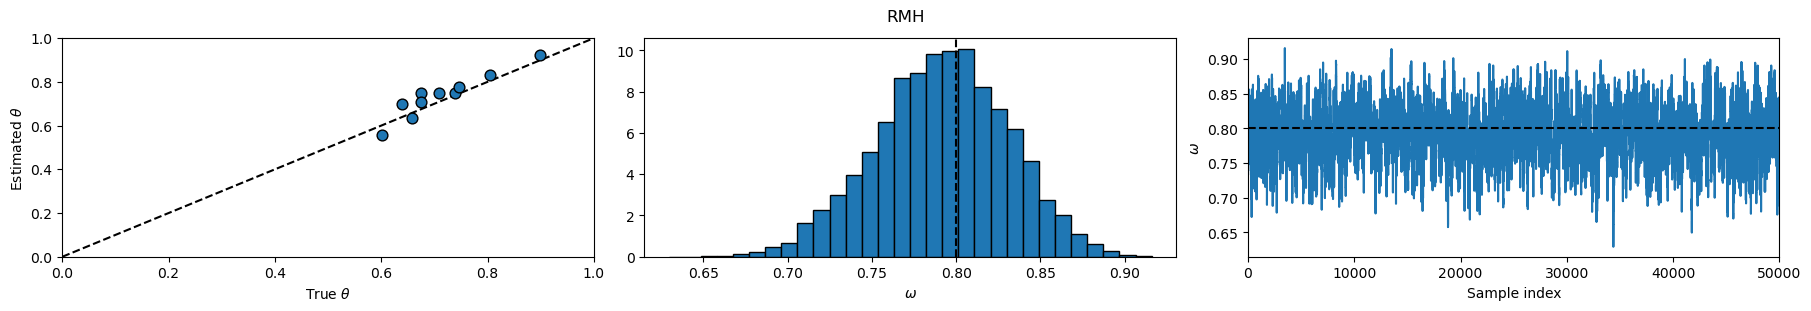

In [17]:
%%time

logdensity_fn = lambda state: HierarchicalCoinflips.loglikelihood_fn()(state) + HierarchicalCoinflips.logprior_fn()(state)
rmh = normal_random_walk(logdensity_fn, sigma=0.02*jnp.eye(HierarchicalCoinflips.get_model_size()))

num_samples = 50_000
num_burn = 50_000
num_thin = 1
num_chains = 1

rmh_states, rmh_info = mcmc_inference_loop(key, model=HierarchicalCoinflips, kernel=rmh, num_samples=num_samples, num_burn=num_burn, num_chains=num_chains, num_thin=num_thin)

_ = plot_states(rmh_states.position, color='tab:blue', title='RMH')

print(f'Acceptance rate: {jnp.mean(1.0*rmh_info.is_accepted):0.3f}')

### HMC

Acceptance rate: 0.960
CPU times: user 8.66 s, sys: 3.09 s, total: 11.8 s
Wall time: 10.8 s


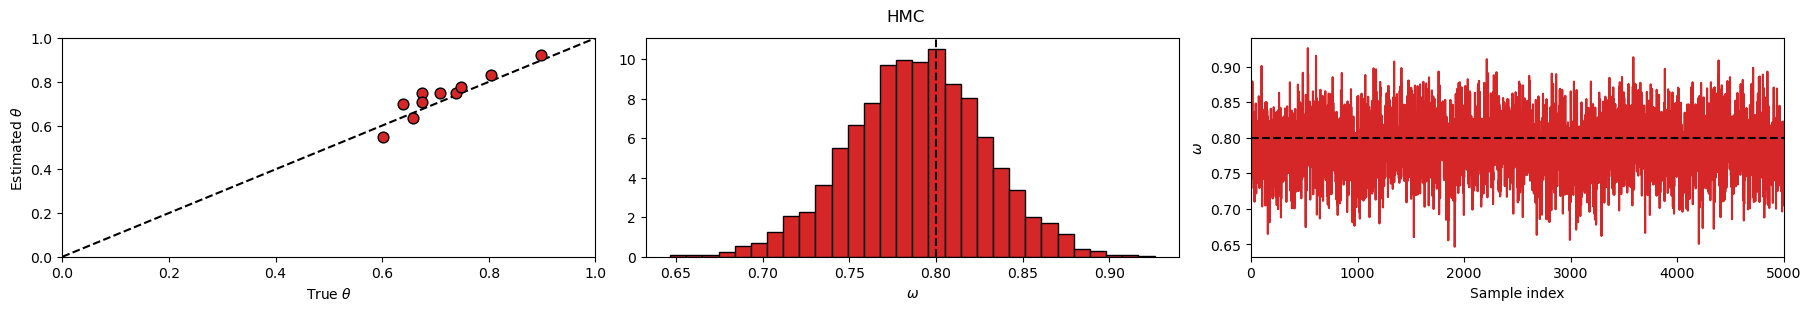

In [18]:
%%time
from blackjax import hmc

logdensity_fn = lambda state: HierarchicalCoinflips.loglikelihood_fn()(state) + HierarchicalCoinflips.logprior_fn()(state)

num_integration_steps = 20  # number of leapfrog steps L
stepsize = 0.01  # discretization time
inverse_mass_matrix = 1.0*jnp.eye(HierarchicalCoinflips.get_model_size())  # approximation of posterior inverse covariance

hmc_kernel = hmc(logdensity_fn, step_size=stepsize, inverse_mass_matrix=inverse_mass_matrix, num_integration_steps=num_integration_steps)

num_samples = 5000
num_burn = 1000
num_thin = 1
num_chains = 1

key, subkey = jrnd.split(key)

hmc_states, hmc_info = mcmc_inference_loop(key, model=HierarchicalCoinflips, kernel=hmc_kernel, num_samples=num_samples, num_burn=num_burn, num_chains=num_chains, num_thin=num_thin)

_ = plot_states(hmc_states.position, color='tab:red', title='HMC')

print(f'Acceptance rate: {jnp.mean(1.0*hmc_info.is_accepted):0.3f}')

### NUTS MCMC

Including window adaptation (gold standard).

Todo: add initial states to the inference loop (i.e., post warm-up)

warm parameters {'step_size': Array(0.64802031, dtype=float64, weak_type=True), 'inverse_mass_matrix': Array([0.00154419, 0.00027783, 0.00100748, 0.00094356, 0.00070433,
       0.00064439, 0.00099791, 0.00111095, 0.00090303, 0.00076594,
       0.00086319], dtype=float64)}
CPU times: user 16.9 s, sys: 493 ms, total: 17.4 s
Wall time: 14.8 s


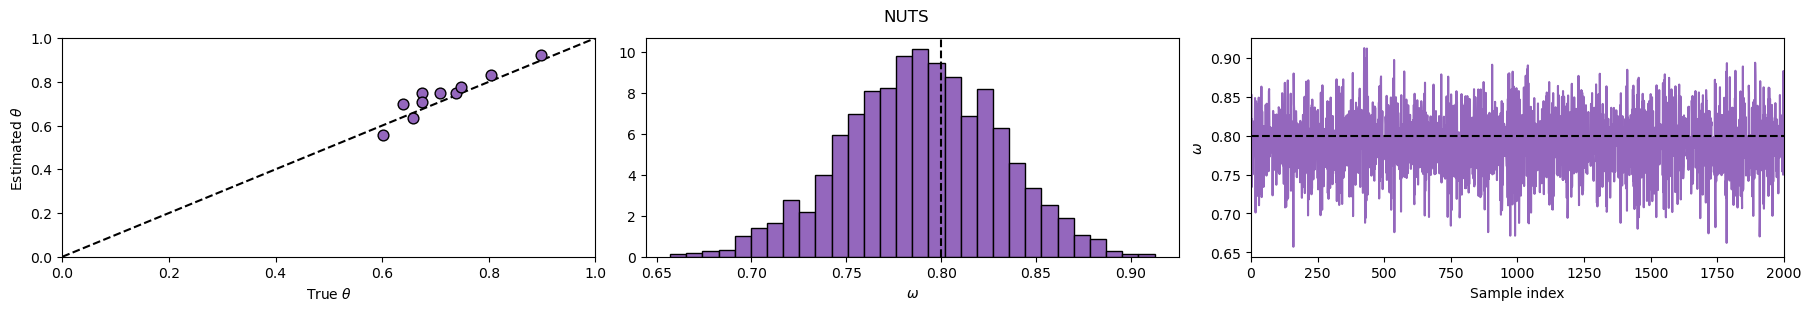

In [19]:
%%time

key, k_init, k_warmup, k_mcmc = jrnd.split(key, 4)

num_samples = 2000
num_burn = 500
num_thin = 1

logdensity_fn = lambda state: HierarchicalCoinflips.loglikelihood_fn()(state) + HierarchicalCoinflips.logprior_fn()(state)

warmup = blackjax.window_adaptation(nuts, logdensity_fn)
(warm_state, warm_parameters), _ = warmup.run(k_warmup, HierarchicalCoinflips.sample_prior(k_init), num_steps=num_burn)  # technically this isn't the burn-in, but it's usable as such
print('warm parameters', warm_parameters)

nuts_kernel = nuts(logdensity_fn, **warm_parameters)

nuts_states, nuts_info = run_chain(k_mcmc, step_fn=nuts_kernel.step, initial_state=warm_state, num_samples=num_burn+num_samples)
nuts_states = jax.tree_util.tree_map(lambda x: x[num_burn::num_thin, ...], nuts_states)

_ = plot_states(nuts_states.position, color='tab:purple', title='NUTS')

### Gibbs MCMC

The Gibbs conditionals are derived automatically by BaMoJax.

Acceptance rate for omega: 0.414
Acceptance rate for theta: 0.283
CPU times: user 7.5 s, sys: 3.21 s, total: 10.7 s
Wall time: 9.87 s


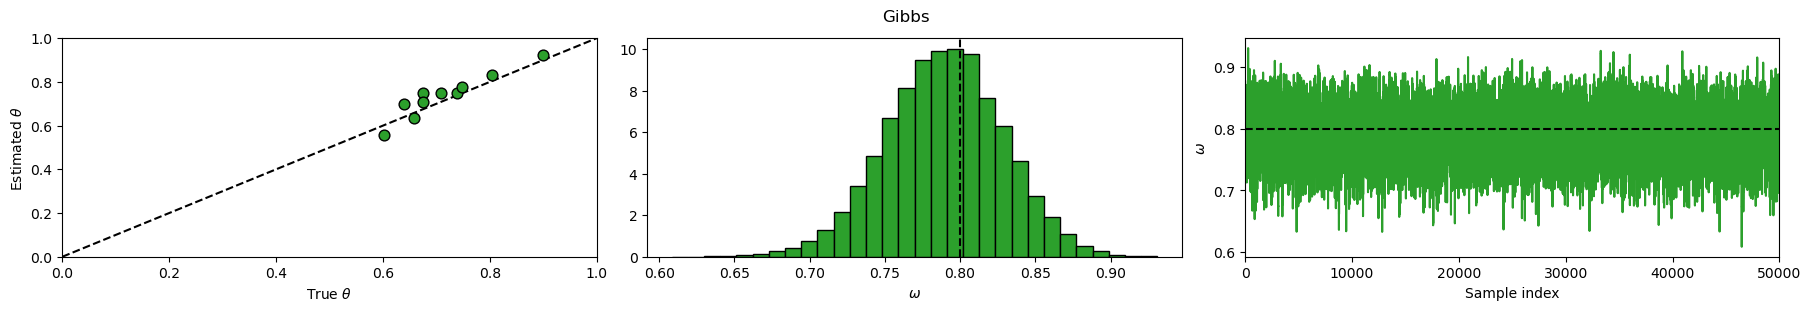

In [20]:
%%time

step_fns = dict(omega=normal_random_walk, theta=normal_random_walk)
step_fn_params = dict(omega=dict(sigma=0.1), theta=dict(sigma=0.02))

gibbs = gibbs_sampler(HierarchicalCoinflips, step_fns=step_fns, step_fn_params=step_fn_params)

num_samples = 50_000
num_burn = 10_000
num_thin = 1
num_chains = 1

key, subkey = jrnd.split(key)

gibbs_states, gibbs_info = mcmc_inference_loop(key, model=HierarchicalCoinflips, kernel=gibbs, num_samples=num_samples, num_burn=num_burn, num_chains=num_chains, num_thin=num_thin)

_ = plot_states(gibbs_states.position, color='tab:green', title='Gibbs')

for node in gibbs_info:
    print(f'Acceptance rate for {node}: {jnp.mean(gibbs_info[node].is_accepted):0.3f}')

# Target acceptance rate for 1D: 0.4, target for ND: 0.234

## SMC

Acceptance rate for omega: 0.413
Acceptance rate for theta: 0.278
Model marginal likelihood: -1114.860799652001
CPU times: user 15.2 s, sys: 686 ms, total: 15.8 s
Wall time: 10.9 s


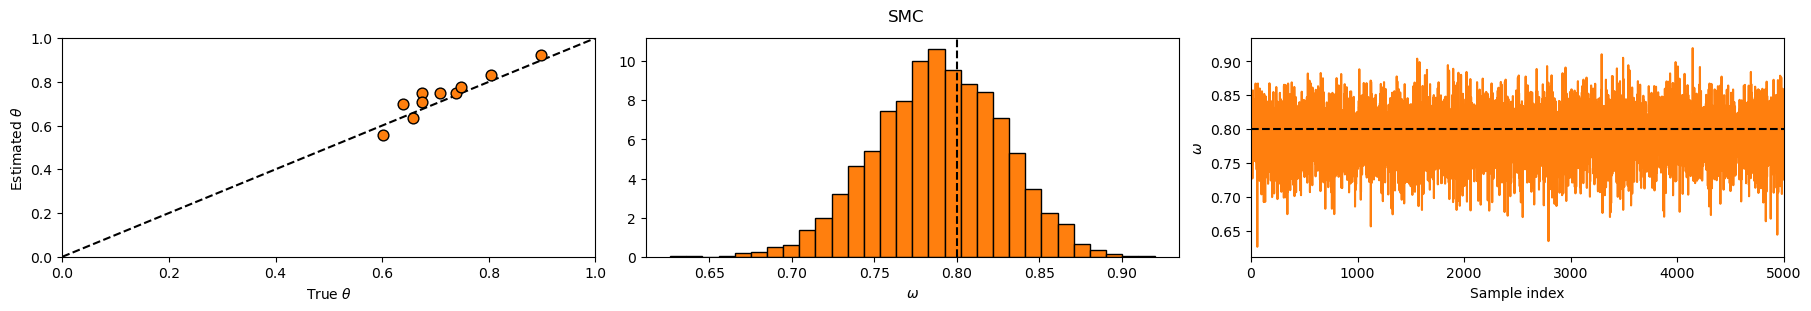

In [21]:
%%time

num_mcmc_steps = 100
num_particles = 5_000

step_fns = dict(omega=normal_random_walk, theta=normal_random_walk)
step_fn_params = dict(omega=dict(sigma=0.1), theta=dict(sigma=0.02))

gibbs = gibbs_sampler(HierarchicalCoinflips, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=HierarchicalCoinflips, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

_ = plot_states(final_state.particles, color='tab:orange', title='SMC')

for node in final_info.update_info:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

print('Model marginal likelihood:', lml)

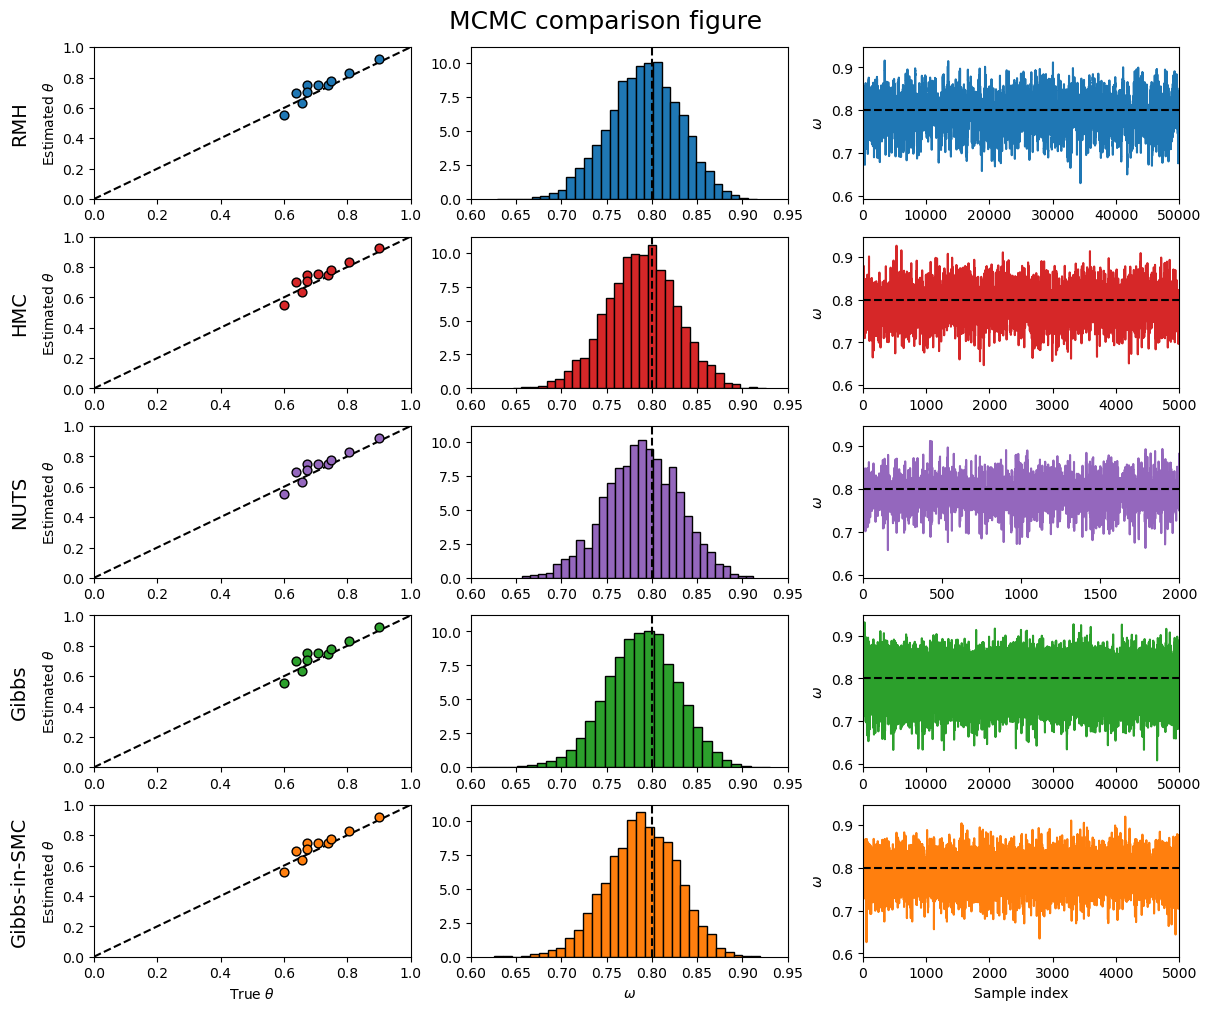

In [22]:
states = [rmh_states.position, hmc_states.position, nuts_states.position, gibbs_states.position, final_state.particles]
colors = ['tab:blue', 'tab:red', 'tab:purple', 'tab:green', 'tab:orange']
names = ['RMH', 'HMC', 'NUTS', 'Gibbs', 'Gibbs-in-SMC']

n_methods = len(names)

_, axes = plt.subplots(nrows=n_methods, ncols=3, constrained_layout=True, figsize=(12, 2*n_methods), sharey='col')

for i in range(n_methods):
    ax = axes[i, 0]
    ax.plot([0, 1], [0, 1], ls='--', color='k', zorder=-5)
    ax.scatter(thetas, jnp.mean(states[i]['theta'], axis=0), s=40, edgecolors='k', c=colors[i])    
    ax.set_ylabel(r'Estimated $\theta$')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax = axes[i, 1]
    ax.hist(states[i]['omega'].flatten(), bins=30,  density=True, facecolor=colors[i], edgecolor='k');
    ax.axvline(x=mode, ls='--', color='k')
    ax.set_xlim([.6, .95])
    ax = axes[i, 2]
    ax.plot(states[i]['omega'].flatten(), color=colors[i])
    ax.axhline(y=mode, ls='--', color='k')
    ax.set_xlim([0, states[i]['omega'].shape[0]])
    ax.set_ylabel(r'$\omega$')

pad = 5
for i, ax in enumerate(axes[:, 0]):
    ax.annotate(names[i], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), xycoords=ax.yaxis.label, textcoords='offset points', size=14, ha='right', va='center', rotation=90)

axes[-1, 0].set_xlabel(r'True $\theta$')
axes[-1, 1].set_xlabel(r'$\omega$')
axes[-1, 2].set_xlabel('Sample index')
plt.suptitle('MCMC comparison figure', fontsize=18);

Multiple chains SMC

Acceptance rates theta: 0.275934
Acceptance rates omega: 0.412794
Acceptance rates theta: 0.279712
Acceptance rates omega: 0.41243
Acceptance rates theta: 0.27985
Acceptance rates omega: 0.412624
Acceptance rates theta: 0.278914
Acceptance rates omega: 0.412226
CPU times: user 29.6 s, sys: 837 ms, total: 30.4 s
Wall time: 24.5 s


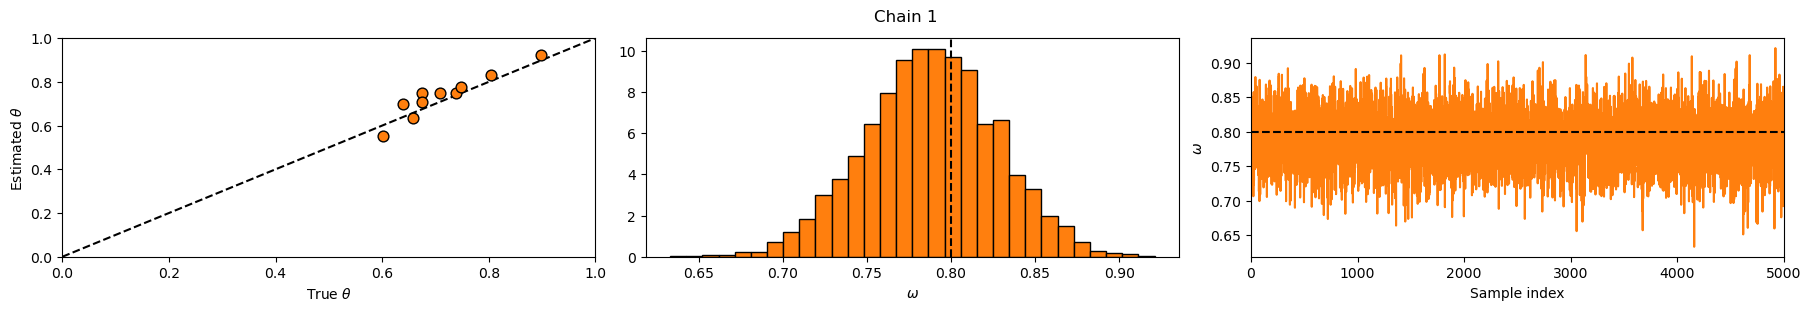

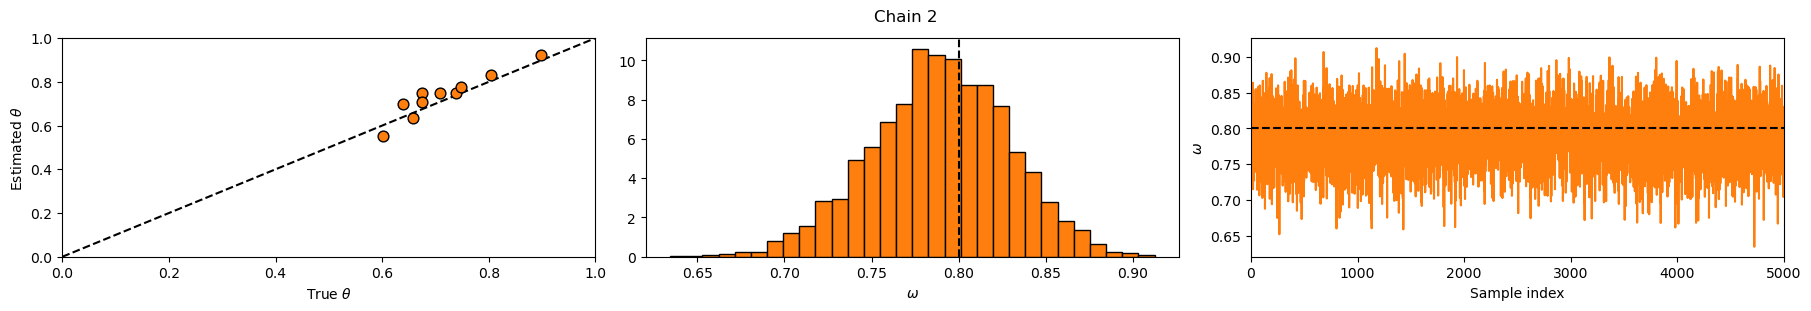

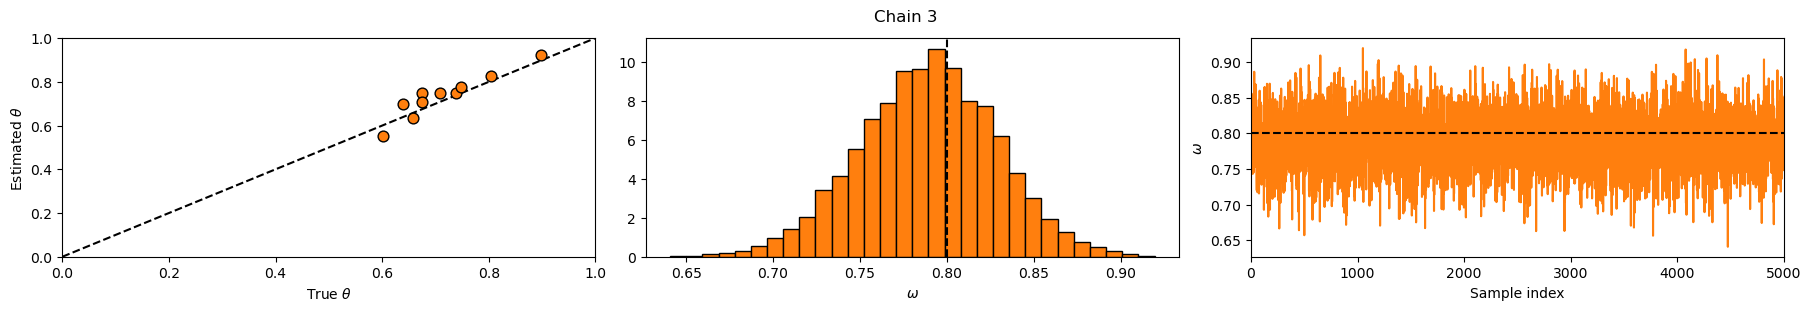

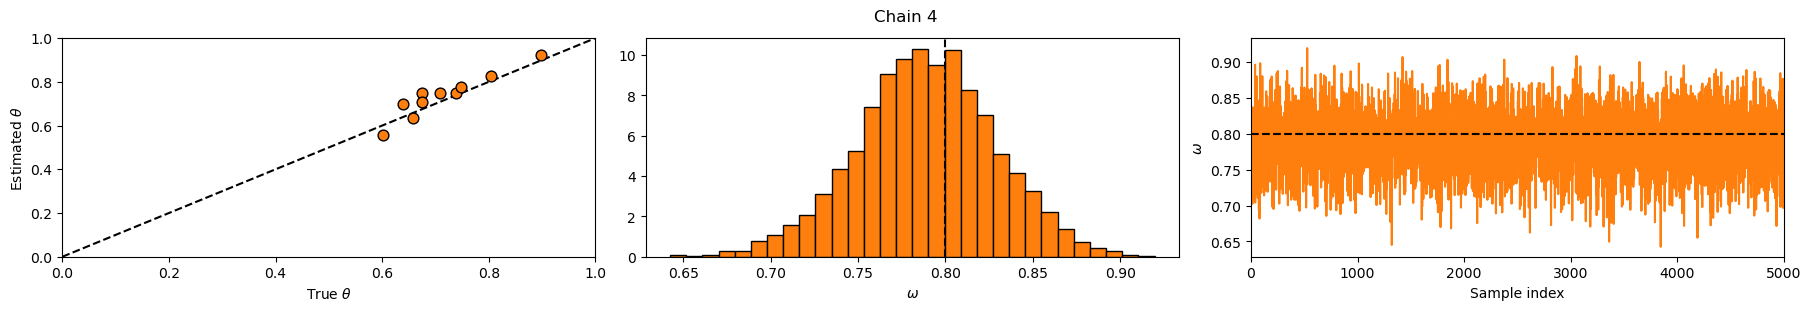

In [23]:
%%time

num_mcmc_steps = 100
num_particles = 5_000
num_chains = 4

step_fns = dict(omega=normal_random_walk, theta=normal_random_walk)
step_fn_params = dict(omega=dict(sigma=0.1), theta=dict(sigma=0.02))

gibbs = gibbs_sampler(HierarchicalCoinflips, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=HierarchicalCoinflips, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps, num_chains=num_chains)

for c in range(num_chains):
    _ = plot_states(jax.tree_util.tree_map(lambda x: x[c,...], final_state.particles), color='tab:orange', title=f'Chain {c+1}')
    print('Acceptance rates theta:', jnp.mean(final_info.update_info['theta'].is_accepted[c, ...]))
    print('Acceptance rates omega:', jnp.mean(final_info.update_info['omega'].is_accepted[c, ...]))

In [24]:
print('max PSRF theta:', jnp.max(potential_scale_reduction(final_state.particles['theta'])))
print('max PSRF omega:', jnp.max(potential_scale_reduction(final_state.particles['omega'])))

max PSRF theta: 1.0001714730443123
max PSRF omega: 0.9999790970840952
